In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings('ignore')
import bz2

In [2]:
with open('embeddings/sgns.zhihu.bigram','wb') as new_file,open('embeddings/sgns.zhihu.bigram.bz2','rb') as file:
    decompressor=bz2.BZ2Decompressor()
    for data in iter(lambda:file.read(100*1024),b''):
        new_file.write(decompressor.decompress(data))

In [3]:
cn_model=KeyedVectors.load_word2vec_format('embeddings/sgns.zhihu.bigram',binary=False,unicode_errors='ignore')

In [4]:
import pandas as pd

In [20]:
data=pd.read_csv('data.csv')

In [21]:
train_texts_orig=list(data.review)
train_target=list(data.label)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,Embedding,LSTM,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard,ReduceLROnPlateau

In [23]:
train_tokens=[]
for text in train_texts_orig:
    text=re.sub('[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+','',text)
    cut=jieba.cut(text)
    cut_list=[i for i in cut]
    for i,word in enumerate(cut_list):
        try:
            cut_list[i]=cn_model.vocab[word].index
        except KeyError:
            cut_list[i]=0
    train_tokens.append(cut_list)
                

In [25]:
num_tokens=[len(tokens) for tokens in train_tokens]
num_tokens=np.array(num_tokens)

In [26]:
np.mean(num_tokens)

67.77707662588539

In [27]:
np.max(num_tokens)

1540

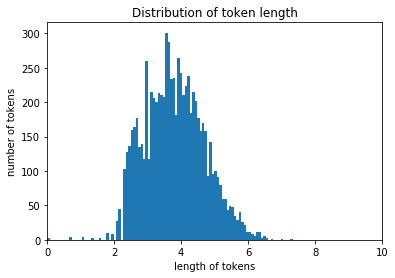

In [28]:
plt.hist(np.log(num_tokens),bins=100)
plt.xlim(0,10)
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of token length')
plt.show()

In [29]:
max_tokens=np.mean(num_tokens)+2*np.std(num_tokens)
max_tokens=int(max_tokens)
max_tokens

222

In [30]:
np.sum(num_tokens<max_tokens)/len(num_tokens)

0.9563425627817128

In [31]:
def reverse_tokens(tokens):
    text=''
    for i in tokens:
        if i != 0:
            text=text+cn_model.index2word[i]
        else:
            text=text+' '
    return text

In [32]:
reverse=reverse_tokens(train_tokens[2])
reverse

'早餐太差无论去多少人那边也不加食品的酒店应该重视一下这个问题了房间本身很好'

In [33]:
train_texts_orig[2]

'早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。'

In [35]:
num_words=50000
embedding_dim=cn_model['山东大学'].shape[0]
embedding_matrix=np.zeros((num_words,embedding_dim))
for i in range(num_words):
    embedding_matrix[i,:]=cn_model[cn_model.index2word[i]]
embedding_matrix=embedding_matrix.astype('float32')

In [36]:
np.sum(cn_model[cn_model.index2word[333]]==embedding_matrix[333])

300

In [37]:
embedding_matrix.shape

(50000, 300)

In [38]:
train_pad=pad_sequences(train_tokens,maxlen=max_tokens,padding='pre',truncating='pre')

In [39]:
train_pad[train_pad>=num_words]=0

In [40]:
len(train_tokens[33])

115

In [41]:
train_target=np.array(train_target)

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train,X_test,y_train,y_test=train_test_split(train_pad,train_target,test_size=0.1,random_state=12)

In [44]:
print(reverse_tokens(X_train[35]))
print('class:',y_train[35])

                                                                                                                                     这个小店可能是因为在 住的外国人比较多服务态度就差了一点素质比较低对于签名还要问你：这是写的什么啊我都不认识入住首先就让你签订一个贵重物品丢失不赔的协议给你的第一感觉就是 不安全感以至于我们出去吃饭的时候都把笔记本电脑背上本来预定了3 了一个晚上 赶快跑吧以后是不会再去了还不能刷卡招待所都不如
class: 0


In [76]:
model=Sequential()

In [77]:
model.add(Embedding(num_words,embedding_dim,weights=[embedding_matrix],input_length=max_tokens,trainable=False))

In [78]:
model.add(Bidirectional(LSTM(units=64,return_sequences=True)))
model.add(LSTM(units=16,return_sequences=False))

In [79]:
model.add(Dense(1,activation='sigmoid'))
optimizer=Adam(lr=1e-3)

In [80]:
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy','AUC'])

In [81]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 222, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 222, 128)          186880    
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 15,196,177
Trainable params: 196,177
Non-trainable params: 15,000,000
_________________________________________________________________


In [82]:
path_checkpoint='sentiment_checkpoint.keras'
checkpoint=ModelCheckpoint(filepath=path_checkpoint,monitor='val_loss',verbose=1,save_weights_only=True,save_best_only=True)

In [83]:
earlystopping=EarlyStopping(monitor='val_loss',patience=5,verbose=1)

In [84]:
lr_reduction=ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-8,patience=0,verbose=1)

In [85]:
callbacks=[earlystopping,checkpoint,lr_reduction]

In [86]:
model.fit(X_train,y_train,validation_split=0.1,epochs=20,batch_size=128,callbacks=callbacks)

Train on 6289 samples, validate on 699 samples
Epoch 1/20
6272/6289 [============================>.] - ETA: 0s - loss: 0.5286 - accuracy: 0.7409 - AUC: 0.7587
Epoch 00001: val_loss improved from inf to 0.38657, saving model to sentiment_checkpoint.keras
6289/6289 [==============================] - 68s 11ms/sample - loss: 0.5278 - accuracy: 0.7415 - AUC: 0.7597 - val_loss: 0.3866 - val_accuracy: 0.8269 - val_AUC: 0.8803
Epoch 2/20
6272/6289 [============================>.] - ETA: 0s - loss: 0.4010 - accuracy: 0.8213 - AUC: 0.8805
Epoch 00002: val_loss did not improve from 0.38657

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
6289/6289 [==============================] - 60s 10ms/sample - loss: 0.4015 - accuracy: 0.8213 - AUC: 0.8802 - val_loss: 0.4861 - val_accuracy: 0.7425 - val_AUC: 0.8270
Epoch 3/20
6272/6289 [============================>.] - ETA: 0s - loss: 0.3989 - accuracy: 0.8184 - AUC: 0.8843
Epoch 00003: val_loss did not improve from 0.38657


In [87]:
result=model.evaluate(X_test,y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

777/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Accuracy:82.88%


In [ ]:
train_texts_orig

In [10]:
data.columns

Index(['label', 'review'], dtype='object')

In [58]:
help(model.compile)

Help on method compile in module tensorflow.python.keras.engine.training:

compile(optimizer='rmsprop', loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None, distribute=None, **kwargs) method of tensorflow.python.keras.engine.sequential.Sequential instance
    Configures the model for training.
    
    Arguments:
        optimizer: String (name of optimizer) or optimizer instance.
            See `tf.keras.optimizers`.
        loss: String (name of objective function), objective function or
            `tf.losses.Loss` instance. See `tf.losses`. If the model has
            multiple outputs, you can use a different loss on each output by
            passing a dictionary or a list of losses. The loss value that will
            be minimized by the model will then be the sum of all individual
            losses.
        metrics: List of metrics to be evaluated by the model during training
            and testing. Typically you w

In [ ]:
tf.keras.metrics.AUC()